# ============== LSTM Model Train & Test Notebook ============= #

In [1]:
# !pip install demoji
# !pip install spacy
# !pip install clean-text

import pandas as pd
import ast
import re
import spacy
import demoji

import numpy as np
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
assert tf.__version__ >= "2.0"

from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, InputLayer, Bidirectional
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# nltk.download('stopwords')

## Preprocessing

In [2]:
df = pd.read_csv('captions_df.csv')
df = df.iloc[:, 1:4]
df = df.dropna().reset_index(drop=True)

In [3]:
# Generate counts of number of post and number of captions (Post can have no captions)

df['num_of_post'] = [0] * len(df['captions'])
df['num_of_captions'] = [0] * len(df['captions'])

y = df['captions'].apply(lambda x: ast.literal_eval(x))
y = y.apply(lambda cap_list: [cap for cap in cap_list if cap is not None])
df['captions'] = y
for i in range(len(df['captions'])):
    x = df['captions'][i]
    df.loc[i, 'num_of_post'] = len(x)
    df.loc[i, 'num_of_captions'] = sum(cap != None for cap in x)

dfe = df.explode('captions').reset_index()

In [4]:
display(dfe)

,index,username,captions,is_fake,num_of_post,num_of_captions
0,0,getlostsg,Finally filming with @outcastssg !! Faster say...,0,50,50
1,0,getlostsg,"Totally did not push back a post, just because...",0,50,50
2,0,getlostsg,Tag a friend who always needs to break the yol...,0,50,50
3,0,getlostsg,Rate the transformation of this shophouse outt...,0,50,50
4,0,getlostsg,"for the first timer ever in @getlostsg , one o...",0,50,50
...,...,...,...,...,...,...
9753,256,copy ai,We're hiring! If you're passionate about what ...,1,100,100
9754,256,copy ai,You deserve a job that pays well and provides ...,1,100,100
9755,256,copy ai,"After months of hard work, you finally have th...",1,100,100
9756,256,copy ai,Every day is a chance to help someone. Every s...,1,100,100


In [5]:
tokenizer = CountVectorizer()
tokenizer.fit_transform(dfe['captions'].dropna())
word_index = tokenizer.vocabulary_
print(f"No. of unique words: {len(word_index)}")

No. of unique words: 30951


### Clean Up Captions (E.g remove emoji, new lines, etc.)

In [6]:
dfe['captions'] = dfe['captions'].str.replace(r'[^\x00-\x7F]+', '', regex=True)

In [7]:
def remove_em(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    return text

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    
    """
        text: a string
        
        return: modified initial string
    """
    if pd.notnull(text):
        text = re.sub(r"(\n)+", " ", text)
        text = remove_em(text)
        text = text.lower() # lowercase text
        text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
        text = ' '.join([ps.stem(w) for w in text.split()])
        text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
        text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
        text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    else:
        text = ''
    
    return text

lstm_df = dfe.copy()
lstm_df['captions'] = lstm_df['captions'].apply(clean_text)
lstm_df['captions_length'] = [len(cap.split()) for cap in lstm_df['captions']]

In [8]:
print("EXAMPLE OF AN EMPTY CAPTION POST BY A BOT: ")
display(lstm_df[lstm_df['username'] == 'breely_wilkey'])

print("EXAMPLES OF CAPTION POST BY A BOT: ")
display(lstm_df[lstm_df['username'] == 'copy ai'])

print("EXAMPLES OF CAPTION POST BY A REAL PERSON: ")
display(lstm_df[lstm_df['username'] == 'ryanxgo'])

print('Shape of lstm_df:', lstm_df.shape)

EXAMPLE OF AN EMPTY CAPTION POST BY A BOT: 


,index,username,captions,is_fake,num_of_post,num_of_captions,captions_length
6372,171,breely_wilkey,,1,0,0,0


EXAMPLES OF CAPTION POST BY A BOT: 


,index,username,captions,is_fake,num_of_post,num_of_captions,captions_length
8971,239,copy ai,spring candl compani ha new line candl smell l...,1,50,50,15
8972,239,copy ai,hey spring air new line candl smell like wildf...,1,50,50,11
8973,239,copy ai,spring ha sprung new wildflow line candl repel...,1,50,50,24
8974,239,copy ai,spring good number mosquito come along repel t...,1,50,50,16
8975,239,copy ai,spring new line candl smell like wildflow,1,50,50,7
...,...,...,...,...,...,...,...
9753,256,copy ai,wer hiring passion handl workload wer look agg...,1,100,100,23
9754,256,copy ai,deserv job pay well provid growth opportunitie...,1,100,100,12
9755,256,copy ai,month hard work final skill knowledg need earn...,1,100,100,12
9756,256,copy ai,everi day chanc help someone everi sale everi ...,1,100,100,16


EXAMPLES OF CAPTION POST BY A REAL PERSON: 


,index,username,captions,is_fake,num_of_post,num_of_captions,captions_length
50,1,ryanxgo,sale,0,49,49,1
51,1,ryanxgo,thecaserco x ryan tan collabor singapor conten...,0,49,49,15
52,1,ryanxgo,final film outcastssg faster say yall think wi...,0,49,49,27
53,1,ryanxgo,final got chanc tri tunxiangnanyang hear manag...,0,49,49,38
54,1,ryanxgo,total push back post becaus miss upload time t...,0,49,49,21
55,1,ryanxgo,tag friend alway need break yolk camera thi in...,0,49,49,15
56,1,ryanxgo,hang pretti cat pretti hous visit hanniwong be...,0,49,49,15
57,1,ryanxgo,first timer ever getlostsg one crew paid thi m...,0,49,49,16
58,1,ryanxgo,useless advic someon ha given lol advic watch ...,0,49,49,21
59,1,ryanxgo,guy collect ani figurines share u comment eh r...,0,49,49,24


Shape of lstm_df: (9758, 7)


In [9]:
int(lstm_df['captions_length'].max())

249

## LSTM Model 1

In [10]:
MAX_TOKENS_NUM = 5000  # Maximum vocab size.
MAX_SEQUENCE_LEN = 250  # Sequence length to pad the outputs to.
EMBEDDING_DIMS = 50

tokenizer = Tokenizer(num_words = MAX_TOKENS_NUM, oov_token = '<OOV>')
tokenizer.fit_on_texts(lstm_df['captions'])
word_index = tokenizer.word_index
print(f"No. of unique words: {len(word_index)}")

train_sequences = tokenizer.texts_to_sequences(lstm_df['captions'])
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

X_train_val, X_test, y_train_val, y_test = train_test_split(train_padded, lstm_df['is_fake'], test_size = 0.20, stratify = lstm_df['is_fake'], random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size = 0.20, stratify = y_train_val, random_state = 42)

# Oversampling
fake_captions_train = X_train[y_train == 1]
real_captions_train = X_train[y_train == 0]
fake_label_train = y_train[y_train == 1].reset_index(drop = True)
real_label_train = y_train[y_train == 0].reset_index(drop = True)

ids = np.arange(len(fake_captions_train))
choices = np.random.choice(ids, len(real_captions_train))

res_pos_features = fake_captions_train[choices]
res_pos_labels = fake_label_train[choices]

resampled_features = np.concatenate([res_pos_features, real_captions_train], axis=0)
resampled_labels = np.concatenate([res_pos_labels, real_label_train], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

X_train = resampled_features
y_train = pd.get_dummies(resampled_labels).values
y_valid = pd.get_dummies(y_valid).values
y_test = pd.get_dummies(y_test).values

print("==========")
print(f"Length of train set is {len(y_train)}")
print(f"Length of validation set is {len(y_valid)}")
print(f"Length of test set is {len(y_test)}")
print("==========")

model1 = Sequential([
    Embedding(5000, EMBEDDING_DIMS),
    LSTM(EMBEDDING_DIMS),
    Dense(2, activation='softmax')
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

epochs = 5
batch_size = 64

history1 = model1.fit(X_train, y_train, epochs=epochs, validation_data = (X_valid, y_valid))

No. of unique words: 25269
Length of train set is 10142
Length of validation set is 1562
Length of test set is 1952
Epoch 1/5
317/317 [==============================] - 29s 83ms/step - loss: 0.6934 - recall: 0.5057 - false_positives: 5013.0000 - true_negatives: 5129.0000 - val_loss: 0.6738 - val_recall: 0.8118 - val_false_positives: 294.0000 - val_true_negatives: 1268.0000
Epoch 2/5
317/317 [==============================] - 26s 81ms/step - loss: 0.6934 - recall: 0.5012 - false_positives: 5059.0000 - true_negatives: 5083.0000 - val_loss: 0.6829 - val_recall: 0.8118 - val_false_positives: 294.0000 - val_true_negatives: 1268.0000
Epoch 3/5
317/317 [==============================] - 28s 88ms/step - loss: 0.6933 - recall: 0.4972 - false_positives: 5099.0000 - true_negatives: 5043.0000 - val_loss: 0.6883 - val_recall: 0.8118 - val_false_positives: 294.0000 - val_true_negatives: 1268.0000
Epoch 4/5
317/317 [==============================] - 25s 79ms/step - loss: 0.6933 - recall: 0.4956 - fal

In [11]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          250000    
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 270,302
Trainable params: 270,302
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Test on test set
model1.evaluate(X_test, y_test, return_dict = True)

# NOTE: The unidirectional LSTM model performance varies quite a bit during train/test, loss remains very high.

61/61 [==============================] - 2s 26ms/step - loss: 0.6902 - recall: 0.8120 - false_positives: 367.0000 - true_negatives: 1585.0000


{'loss': 0.6902057528495789,
 'recall': 0.8119876980781555,
 'false_positives': 367.0,
 'true_negatives': 1585.0}

C:\Users\bryan\AppData\Local\Temp\ipykernel_17812\2853410774.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


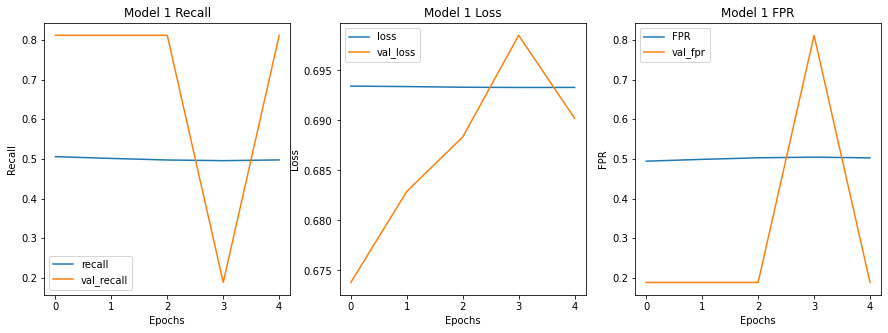

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
model_num = 1

ax2.plot(history1.history['loss'])
ax2.plot(history1.history['val_loss'])
ax2.set_title(f"Model {model_num} Loss")
ax2.set(xlabel="Epochs", ylabel="Loss")
ax2.legend(['loss', 'val_loss'])

ax1.plot(history1.history['recall'])
ax1.plot(history1.history['val_recall'])
ax1.set_title(f"Model {model_num} Recall")
ax1.set(xlabel="Epochs", ylabel="Recall")
ax1.legend(['recall', 'val_recall'])

total_train_fake = [x + y for x, y in zip(history1.history['false_positives'], history1.history['true_negatives'])]
total_val_fake = [x + y for x, y in zip(history1.history['val_false_positives'], history1.history['val_true_negatives'])]
ax3.plot([i/j for i, j in zip(history1.history['false_positives'],total_train_fake)])
ax3.plot([i/j for i, j in zip(history1.history['val_false_positives'],total_val_fake)])
ax3.set_title(f"Model {model_num} FPR")
ax3.set(xlabel="Epochs", ylabel="FPR")
ax3.legend(['FPR', 'val_fpr'])

fig.show()

## LSTM Model 2

In [14]:
MAX_TOKENS_NUM = 5000  # Maximum vocab size.
MAX_SEQUENCE_LEN = 250  # Sequence length to pad the outputs to.
EMBEDDING_DIMS = 50

tokenizer = Tokenizer(num_words = MAX_TOKENS_NUM, oov_token = '<OOV>')
tokenizer.fit_on_texts(lstm_df['captions'])
word_index = tokenizer.word_index
print(f"No. of unique words: {len(word_index)}")

train_sequences = tokenizer.texts_to_sequences(lstm_df['captions'])
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

X_train_val, X_test, y_train_val, y_test = train_test_split(train_padded, lstm_df['is_fake'], test_size = 0.20, stratify = lstm_df['is_fake'], random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size = 0.20, stratify = y_train_val, random_state = 42)

# Oversampling
fake_captions_train = X_train[y_train == 1]
real_captions_train = X_train[y_train == 0]
fake_label_train = y_train[y_train == 1].reset_index(drop = True)
real_label_train = y_train[y_train == 0].reset_index(drop = True)

ids = np.arange(len(fake_captions_train))
choices = np.random.choice(ids, len(real_captions_train))

res_pos_features = fake_captions_train[choices]
res_pos_labels = fake_label_train[choices]

resampled_features = np.concatenate([res_pos_features, real_captions_train], axis=0)
resampled_labels = np.concatenate([res_pos_labels, real_label_train], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

X_train = resampled_features
y_train = pd.get_dummies(resampled_labels).values
y_valid = pd.get_dummies(y_valid).values
y_test = pd.get_dummies(y_test).values

model = Sequential([
    Embedding(MAX_TOKENS_NUM, EMBEDDING_DIMS),
    Bidirectional(LSTM(EMBEDDING_DIMS)),
    Dense(EMBEDDING_DIMS, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, validation_data = (X_valid, y_valid))

No. of unique words: 25269
Epoch 1/5
317/317 [==============================] - 47s 133ms/step - loss: 0.2058 - recall_1: 0.9104 - false_positives_1: 909.0000 - true_negatives_1: 9233.0000 - val_loss: 0.1129 - val_recall_1: 0.9648 - val_false_positives_1: 55.0000 - val_true_negatives_1: 1507.0000
Epoch 2/5
317/317 [==============================] - 38s 119ms/step - loss: 0.0431 - recall_1: 0.9870 - false_positives_1: 132.0000 - true_negatives_1: 10010.0000 - val_loss: 0.1359 - val_recall_1: 0.9648 - val_false_positives_1: 55.0000 - val_true_negatives_1: 1507.0000
Epoch 3/5
317/317 [==============================] - 43s 136ms/step - loss: 0.0303 - recall_1: 0.9921 - false_positives_1: 80.0000 - true_negatives_1: 10062.0000 - val_loss: 0.1746 - val_recall_1: 0.9616 - val_false_positives_1: 60.0000 - val_true_negatives_1: 1502.0000
Epoch 4/5
317/317 [==============================] - 41s 131ms/step - loss: 0.0255 - recall_1: 0.9940 - false_positives_1: 61.0000 - true_negatives_1: 10081.00

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          250000    
                                                                 
 bidirectional (Bidirectiona  (None, 100)              40400     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 295,552
Trainable params: 295,552
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Test on test set
model.evaluate(X_test, y_test, return_dict = True)

61/61 [==============================] - 3s 43ms/step - loss: 0.2238 - recall_1: 0.9559 - false_positives_1: 86.0000 - true_negatives_1: 1866.0000


{'loss': 0.22381317615509033,
 'recall_1': 0.9559426307678223,
 'false_positives_1': 86.0,
 'true_negatives_1': 1866.0}

C:\Users\bryan\AppData\Local\Temp\ipykernel_17812\4159078329.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


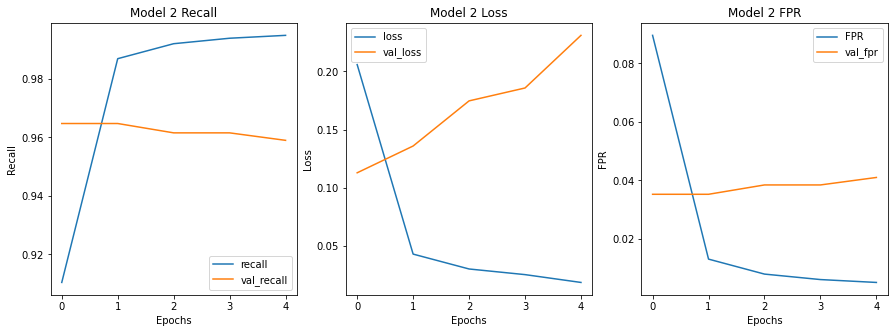

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
model_num = 2

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title(f"Model {model_num} Loss")
ax2.set(xlabel="Epochs", ylabel="Loss")
ax2.legend(['loss', 'val_loss'])

ax1.plot(history.history['recall_1'])
ax1.plot(history.history['val_recall_1'])
ax1.set_title(f"Model {model_num} Recall")
ax1.set(xlabel="Epochs", ylabel="Recall")
ax1.legend(['recall', 'val_recall'])

total_train_fake = [x + y for x, y in zip(history.history['false_positives_1'], history.history['true_negatives_1'])]
total_val_fake = [x + y for x, y in zip(history.history['val_false_positives_1'], history.history['val_true_negatives_1'])]
ax3.plot([i/j for i, j in zip(history.history['false_positives_1'],total_train_fake)])
ax3.plot([i/j for i, j in zip(history.history['val_false_positives_1'],total_val_fake)])
ax3.set_title(f"Model {model_num} FPR")
ax3.set(xlabel="Epochs", ylabel="FPR")
ax3.legend(['FPR', 'val_fpr'])

fig.show()

## LSTM Model 3

In [18]:
MAX_TOKENS_NUM = 5000  # Maximum vocab size.
MAX_SEQUENCE_LEN = 250  # Sequence length to pad the outputs to.
EMBEDDING_DIMS = 50

tokenizer = Tokenizer(num_words = MAX_TOKENS_NUM, oov_token = '<OOV>')
tokenizer.fit_on_texts(lstm_df['captions'])
word_index = tokenizer.word_index
print(f"No. of unique words: {len(word_index)}")

train_sequences = tokenizer.texts_to_sequences(lstm_df['captions'])
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

X_train_val, X_test, y_train_val, y_test = train_test_split(train_padded, lstm_df['is_fake'], test_size = 0.20, stratify = lstm_df['is_fake'], random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size = 0.20, stratify = y_train_val, random_state = 42)

# Oversampling
fake_captions_train = X_train[y_train == 1]
real_captions_train = X_train[y_train == 0]
fake_label_train = y_train[y_train == 1].reset_index(drop = True)
real_label_train = y_train[y_train == 0].reset_index(drop = True)

ids = np.arange(len(fake_captions_train))
choices = np.random.choice(ids, len(real_captions_train))

res_pos_features = fake_captions_train[choices]
res_pos_labels = fake_label_train[choices]

resampled_features = np.concatenate([res_pos_features, real_captions_train], axis=0)
resampled_labels = np.concatenate([res_pos_labels, real_label_train], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

X_train = resampled_features
y_train = pd.get_dummies(resampled_labels).values
y_valid = pd.get_dummies(y_valid).values
y_test = pd.get_dummies(y_test).values

model3 = Sequential([
    Embedding(MAX_TOKENS_NUM, EMBEDDING_DIMS),
    Bidirectional(LSTM(EMBEDDING_DIMS)),
    Dense(2, activation='softmax')
])

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

epochs = 5
batch_size = 64

history3 = model3.fit(X_train, y_train, epochs=epochs, validation_data = (X_valid, y_valid))

No. of unique words: 25269
Epoch 1/5
317/317 [==============================] - 46s 133ms/step - loss: 0.2573 - recall_2: 0.8968 - false_positives_2: 1047.0000 - true_negatives_2: 9095.0000 - val_loss: 0.0979 - val_recall_2: 0.9693 - val_false_positives_2: 48.0000 - val_true_negatives_2: 1514.0000
Epoch 2/5
317/317 [==============================] - 37s 116ms/step - loss: 0.0590 - recall_2: 0.9827 - false_positives_2: 175.0000 - true_negatives_2: 9967.0000 - val_loss: 0.1330 - val_recall_2: 0.9603 - val_false_positives_2: 62.0000 - val_true_negatives_2: 1500.0000
Epoch 3/5
317/317 [==============================] - 38s 119ms/step - loss: 0.0385 - recall_2: 0.9894 - false_positives_2: 108.0000 - true_negatives_2: 10034.0000 - val_loss: 0.1283 - val_recall_2: 0.9661 - val_false_positives_2: 53.0000 - val_true_negatives_2: 1509.0000
Epoch 4/5
317/317 [==============================] - 38s 118ms/step - loss: 0.0299 - recall_2: 0.9922 - false_positives_2: 79.0000 - true_negatives_2: 10063.0

In [19]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          250000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 290,602
Trainable params: 290,602
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Test on test set
model3.evaluate(X_test, y_test, return_dict = True)

61/61 [==============================] - 2s 33ms/step - loss: 0.1491 - recall_2: 0.9631 - false_positives_2: 72.0000 - true_negatives_2: 1880.0000


{'loss': 0.14911535382270813,
 'recall_2': 0.9631147384643555,
 'false_positives_2': 72.0,
 'true_negatives_2': 1880.0}

C:\Users\bryan\AppData\Local\Temp\ipykernel_17812\3687250987.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


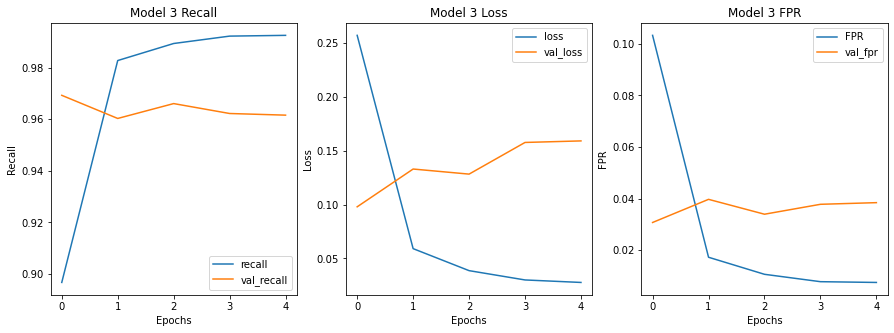

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
model_num = 3

ax2.plot(history3.history['loss'])
ax2.plot(history3.history['val_loss'])
ax2.set_title(f"Model {model_num} Loss")
ax2.set(xlabel="Epochs", ylabel="Loss")
ax2.legend(['loss', 'val_loss'])

ax1.plot(history3.history['recall_2'])
ax1.plot(history3.history['val_recall_2'])
ax1.set_title(f"Model {model_num} Recall")
ax1.set(xlabel="Epochs", ylabel="Recall")
ax1.legend(['recall', 'val_recall'])

total_train_fake = [x + y for x, y in zip(history3.history['false_positives_2'], history3.history['true_negatives_2'])]
total_val_fake = [x + y for x, y in zip(history3.history['val_false_positives_2'], history3.history['val_true_negatives_2'])]
ax3.plot([i/j for i, j in zip(history3.history['false_positives_2'],total_train_fake)])
ax3.plot([i/j for i, j in zip(history3.history['val_false_positives_2'],total_val_fake)])
ax3.set_title(f"Model {model_num} FPR")
ax3.set(xlabel="Epochs", ylabel="FPR")
ax3.legend(['FPR', 'val_fpr'])

fig.show()

# Extra Testing

In [22]:
lab = ['NOT FAKE', 'FAKE']

cleaned_text = clean_text("Happy to meet Governor of South Australia Frances Adamson this afternoon. We reaffirmed the excellent relations between Singapore and Australia, as well as close economic and cultural ties between Singapore and South Australia. South Australia and its capital city of Adelaide have been the torchbearer for innovation and new ideas in areas such as renewable energy, food, education as well as arts and culture. I look forward to further cooperation with South Australia in these areas.")
example = tokenizer.texts_to_sequences([cleaned_text])
example_pad = pad_sequences(example, maxlen=30, padding='post', truncating='post')
pred = np.argmax(model.predict(example_pad), axis = -1)

for p in pred:
    print(lab[p])

1/1 [==============================] - 1s 799ms/step
NOT FAKE


In [23]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(lstm_df['captions'][10])

caifan must <OOV> watch latest vlog havent got giveaway promo <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
caifan must haves watch latest vlog havent got giveaway promo lehhhh
